In [48]:
# NLP stuff
from textblob import classifiers
from newsapi import NewsApiClient
from fastai.fastai.imports import *
from fastai.old.fastai.structured import *
from datetime import datetime, timedelta

# RF stuff
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display
import pandas as pd
from sklearn import metrics

In [49]:
# finds RMSE between the prediction and the actuak
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

# function for print r2 and RMSE of training data and validation data
# also print oob_score (out of box score) if the model had that parameter
def print_score(rf):
    res = ["RMSE " + str(rmse(rf.predict(X_valid), y_valid)), "R^2 " + str(rf.score(X_valid, y_valid))]
    if hasattr(rf, 'oob_score_'): res.append(rf.oob_score_)
    print(res)
    
# splits dataset based on how many you want to train/validate
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [130]:
# uses the data from 'From Group to Individual Labels using Deep Features', Kotzias et. al to train sentiment classifier
PATH1 = 'data/SentimentData/amazon_cells_labelled.txt'
PATH2 = 'data/SentimentData/imdb_labelled.txt'
PATH3 = 'data/SentimentData/yelp_labelled.txt'

amazon_data = pd.read_csv(PATH1, sep='\t', header=None, names=['sentence', 'sentiment'])
imdb_data = pd.read_csv(PATH2, sep='\t', header=None, names=['sentence', 'sentiment'])
yelp_data = pd.read_csv(PATH3, sep='\t', header=None, names=['sentence', 'sentiment'])

# makes the combined data
total_data = amazon_data
total_data = total_data.append(imdb_data, ignore_index=True)
total_data = total_data.append(yelp_data, ignore_index=True)

train_data_full = [tuple(x) for x in total_data.values]
train_data = train_data_full[:2000]
print(len(train_data))

print('training NLP classifier...')
print()
classifier = classifiers.NaiveBayesClassifier(train_data)
classifier.train()
print('done. Accuracy: ')
classifier.accuracy(train_data_full[2000:])

2000
training NLP classifier...

done. Accuracy: 


0.7593582887700535

In [131]:
key = '8b8428b3603940ef8485d39a6eb526f2'
news = NewsApiClient(api_key=key)

companiesTotal = {'Synchrony Financial': [],
            '3M': [],
            'Bayer': [],
            'Honeywell': []}

ARTICLE_COUNT = 5
# finds the relevant news articles for a company on a day
# current_date should be in form "YYYY-MM-DAY"
def parse_articles_on_date(company_name, current_date):
    # this calculates the day one week ago
    DAYS_BACK = 1
    year, month, day = tuple(current_date.split('-'))
    new_date = datetime(int(year), int(month), int(day)) - timedelta(DAYS_BACK)
    start_day = str(new_date)[:10]
    
    company_data = []
    query = company_name + " News"
    all_articles = news.get_everything(q=query, from_param=start_day,to=current_date, language='en', sort_by='relevancy')
    article_data = all_articles['articles']
    for i in range(ARTICLE_COUNT):
        try:
            titlePlusSummary = article_data[i]['title'] + '. ' + article_data[i]['description']
            company_data.append(titlePlusSummary)
        except:
            break
    return company_data

# takes data found from parse_articles_on_date and determines the score using the classifier
def calculate_score(classifer, company_data):
    count = 0
    output = 0
    for summary in company_data:
        try:
            output += classifier.prob_classify(summary).prob(1)
            count += 1
        except:
            continue
    if count > 0:
        return output / count
    else:
        return 0

# a wrapper on the previous two functions
def article_scorer_wrapper(classifier, company_name, current_date):
    company_data = parse_articles_on_date(company_name, current_date)
    return calculate_score(classifier, company_data)

In [133]:
PATH = 'data/BAYZF-TIME_SERIES_INTRADAY.csv'
PATH_SUPPL = 'data/BAYZF-TIME_SERIES_DAILY.csv'
dateColumn = "timestamp"

df_BAYZF = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_BAYZF.rename(index=str, columns={"open": "sale_price"}, inplace=True)
df_SUPPL = pd.read_csv(PATH_SUPPL, low_memory=False, parse_dates=[dateColumn])
data_suppl = df_SUPPL["open"].values

add_datepart(df_BAYZF, dateColumn, time=True)
add_datepart(df_SUPPL, dateColumn, time=True)

In [134]:
start_hour = 9
start_minute = 30
end_hour = 4
end_minute = 0

def day_to_start_price_map(df, price_field, indices=True, toCount=False):
    # map of unique_days to their starting price
    unique_days = {}
    counts = {}
    for row in range(len(df[price_field])):
        year = df["timestampYear"][row]
        month = df["timestampMonth"][row]
        week = df["timestampWeek"][row]
        day = df["timestampDay"][row]
        data = (year, month, week, day)
        if indices:
            if data in unique_days:
                unique_days[data].append(row)
            else:
                unique_days[data] = [row]
        else:         
            if data not in unique_days:
                unique_days[data] = df[price_field][row]
            else:
                unique_days[data] = df[price_field][row]
        if toCount:
            if data in counts:
                counts[data] += 1
            else:
                counts[data] = 1
    if toCount:
        return unique_days, counts
    
    return unique_days

# 6 hours * 12 five min intervals per hour + 6 five min intervals from 9:30 to 10
total_intervals = 6*12 + 6

# very long function that was used specifically for df_BAYZF as its data was only recorded when a sale was made
# turns it into data that is recored every 5 minutes from 9:30 to 4pm
def create_new_df(df_main, df_suppl, company_name, classifier):
    def assign_interval(hour, minute):
            if hour == 9:
                intervalCheck = (minute - 30) / 5
            else:
                intervalCheck = minute / 5 + (hour - 10)*12 + 6
            return intervalCheck
    
    day_to_price = day_to_start_price_map(df_main, "sale_price", True)
    day_to_price_start = day_to_start_price_map(df_suppl, "open", False)
    day_to_price_close = day_to_start_price_map(df_suppl, "close", False)
    first=True    
    for day_info in day_to_price:
        dataOpen = np.array([day_to_price_start[day_info] for interval in range(total_intervals)])
        dataClose = np.array([day_to_price_close[day_info] for interval in range(total_intervals)])
        dataPrice = []
        list_counter = -1
        indexInDf = day_to_price[day_info][list_counter]
        price = day_to_price_start[day_info]
        hourChange = df_main["timestampHour"][indexInDf]
        minuteChange = df_main["timestampMinute"][indexInDf]
        intervalCheck = assign_interval(hourChange, minuteChange)
        for interval in range(total_intervals):
            if interval == intervalCheck:
                # updates price as a change has been detected
                price = df_main["sale_price"][indexInDf]
                try:
                    # updates the list counter and the other variables
                    list_counter -= 1
                    indexInDf = day_to_price[day_info][list_counter]
                    hourChange = df_main["timestampHour"][indexInDf]
                    minuteChange = df_main["timestampMinute"][indexInDf]
                    intervalCheck = assign_interval(hourChange, minuteChange)
                except:
                    pass
            dataPrice.append(price)
            
        dataPrice = np.array(dataPrice)
        hours = np.array([0 for interval in range(total_intervals)])
        minutes = np.array([0 for interval in range(total_intervals)])
        for i in range(total_intervals):
            if i < 6:
                hours[i] = 9
                minutes[i] = 30 + 5*i
            else:
                minutes[i] = (5*(i-6) % 60)
                if i < 18:
                    hours[i] = 10
                elif i < 30:
                    hours[i] = 11
                elif i < 42:
                    hours[i] = 12
                elif i < 54:
                    hours[i] = 1
                elif i < 66:
                    hours[i] = 2
                else:
                    hours[i] = 3
                    
        year, month, week, day = day_info
        year = str(year)
        month = str(month)
        day = str(day)
        if (len(month) == 1):
            month = '0' + month
        if (len(day) == 1):
            day = '0' + day
        current_date = year + "-" + month + "-" + day
        sentiment_score = article_scorer_wrapper(classifier=classifier, company_name=company_name, current_date=current_date)
        sentiment_score_as_list = [sentiment_score for x in range(total_intervals)]
        toAdd = {"sale_price": dataPrice,
                 "price_close": dataClose,
                 "open": dataOpen,
                 "sentiment": sentiment_score_as_list,
                 "timestamp": str(month) + "/" + str(day) + "/" + str(year),
                 "hour": hours,
                 "minute": minutes}
        dfAdd = pd.DataFrame.from_dict(toAdd)
        
        if first:
            df_toReturn = dfAdd
            first=False
        else:
            df_toReturn = df_toReturn.append(dfAdd, ignore_index=True)
            
    return df_toReturn

In [135]:
df_BAYZF = create_new_df(df_BAYZF, df_SUPPL, company_name='Bayer', classifier=classifier)
add_datepart(df_BAYZF, "timestamp")

In [136]:
df_BAYZF

,sale_price,price_close,open,sentiment,hour,minute,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampDayofyear,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampElapsed
0,74.4300,73.8380,74.4300,0.674948,9,30,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
1,74.4300,73.8380,74.4300,0.674948,9,35,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
2,74.4300,73.8380,74.4300,0.674948,9,40,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
3,74.4300,73.8380,74.4300,0.674948,9,45,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
4,74.4300,73.8380,74.4300,0.674948,9,50,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
5,74.4300,73.8380,74.4300,0.674948,9,55,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
6,74.4300,73.8380,74.4300,0.674948,10,0,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
7,74.4300,73.8380,74.4300,0.674948,10,5,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
8,74.4300,73.8380,74.4300,0.674948,10,10,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400
9,74.4300,73.8380,74.4300,0.674948,10,15,2019,2,7,14,3,45,False,False,False,False,False,False,1550102400


In [148]:
"""
kernel for preparing df_BAYZF to be passed into Random Forest and then actually creating the model
will use OPEN and CLOSE on a given day to predict INTERDAY price changes
close will come from another model that predicts close
"""
to_predict = "sale_price"
# proc_df is a fastai function that turns a df into its paramater data and output
# proc_df can also drop additional columns that you specify, and it fills in any missing values with the median
# to allow for continuous data
result = proc_df(df_BAYZF, y_fld=to_predict)
# df is all the columns of df_BAYZF minus the one being predicted
df = result[0]
# y is the output being predicted (in this case instantaneous day price)
y = result[1]

# this removes any instances where y is not an actual value as well as removing that row from the corresponding df row
to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = total_intervals*5 # predict the last 5 days
n_train = len(df) - n_valid
# splits the data, note the data is NOT shuffled as it's already in order, so using first 80 rows to predict last 20
# is equivalent to predicting 20 rows "in the future"
raw_train, raw_valid = split_vals(df_BAYZF, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

# at last, makes the Random Forest Model using tuned hyperparameters
rf_BAYZF = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_BAYZF.fit(X_train, y_train)
print_score(rf_BAYZF)

['RMSE 0.636057518162676', 'R^2 0.21350376501287335']


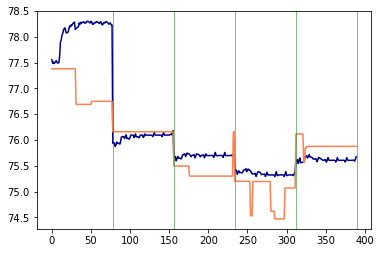

In [149]:
# code for plotting the predictions against the expected over "time"
preds = rf_BAYZF.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()

In [150]:
rf_feat_importance(rf_BAYZF, df)

,cols,imp
1,open,0.391384
0,price_close,0.248086
17,timestampElapsed,0.121344
8,timestampDay,0.060816
2,sentiment,0.054087
10,timestampDayofyear,0.050701
3,hour,0.030371
9,timestampDayofweek,0.026054
7,timestampWeek,0.011621
4,minute,0.005536


In [160]:
# "open" in the dataset really means the sale price, so this function creates a new open column and also a sentiment column
def create_open_and_sentiment_cols(df, company_name, classifier):
    res = day_to_start_price_map(df, "sale_price", False, True)
    day_to_price_start = res[0]
    counts = res[1]
    first = True
    for day_info in day_to_price_start:
        
        year, month, week, day = day_info
        year = str(year)
        month = str(month)
        day = str(day)
        if (len(month) == 1):
            month = '0' + month
        if (len(day) == 1):
            day = '0' + day
        current_date = year + "-" + month + "-" + day
        
        dataOpen = np.array([day_to_price_start[day_info] for interval in range(counts[day_info])])
        sentiment_score = article_scorer_wrapper(classifier=classifier, company_name=company_name, current_date=current_date)
        sentiment_score_as_list = np.array([sentiment_score for x in range(counts[day_info])])
        if first:
            first = False
            net_open_data = dataOpen
            net_sentiment_data = sentiment_score_as_list
        else:
            net_open_data = np.append(net_open_data, dataOpen)
            net_sentiment_data = np.append(net_sentiment_data, sentiment_score_as_list)
    df['open'] = net_open_data
    df['sentiment'] = net_sentiment_data
    return df

In [162]:
PATH = 'data/MMM-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_MMM = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_MMM.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_MMM, dateColumn, time=True)

df_MMM = create_open_and_sentiment_cols(df_MMM, company_name="3M", classifier=classifier)
df_MMM

,sale_price,high,low,close,volume,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,...,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed,open,sentiment
0,208.7100,208.8800,208.6500,208.8500,100664,2019,2,7,15,4,...,False,False,False,False,16,0,0,1550246400,206.81,0.718665
1,208.5700,208.6900,208.5700,208.6900,25914,2019,2,7,15,4,...,False,False,False,False,15,59,0,1550246340,206.81,0.718665
2,208.5600,208.6000,208.5300,208.5300,13805,2019,2,7,15,4,...,False,False,False,False,15,58,0,1550246280,206.81,0.718665
3,208.5300,208.5900,208.4900,208.5900,16554,2019,2,7,15,4,...,False,False,False,False,15,57,0,1550246220,206.81,0.718665
4,208.4100,208.5100,208.4100,208.5100,16589,2019,2,7,15,4,...,False,False,False,False,15,56,0,1550246160,206.81,0.718665
5,208.2700,208.3700,208.2700,208.3700,10917,2019,2,7,15,4,...,False,False,False,False,15,55,0,1550246100,206.81,0.718665
6,208.2100,208.3000,208.2100,208.3000,10344,2019,2,7,15,4,...,False,False,False,False,15,54,0,1550246040,206.81,0.718665
7,208.2150,208.2200,208.2150,208.2200,6109,2019,2,7,15,4,...,False,False,False,False,15,53,0,1550245980,206.81,0.718665
8,208.2400,208.3800,208.2400,208.2600,12973,2019,2,7,15,4,...,False,False,False,False,15,52,0,1550245920,206.81,0.718665
9,208.4000,208.4000,208.2400,208.2400,10646,2019,2,7,15,4,...,False,False,False,False,15,51,0,1550245860,206.81,0.718665


In [166]:
to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_MMM, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 200 # predict part of the last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_MMM, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_MMM = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5, oob_score=True)
rf_MMM.fit(X_train, y_train)
print_score(rf_MMM)

['RMSE 0.2558811425582899', 'R^2 0.0936478511033293', 0.9991443293188222]


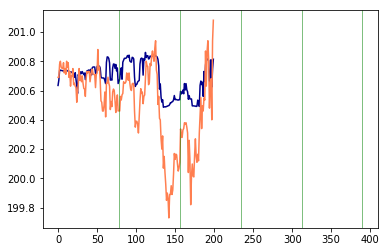

In [167]:
preds = rf_MMM.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()